In [1]:
import torch
import numpy as np

from lafomo.datasets import ToySpatialTranscriptomics
from lafomo.options import VariationalOptions
from lafomo.utilities.torch import save, load
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

from fenics import *
from fenics_adjoint import *

import torch_fenics

In [2]:
import pandas as pd
data = pd.read_csv('../data/demToy1GPGene.csv')
data = pd.read_csv('../data/demToy1GPmRNA.csv')
display(data.head(5))

vals = data.values


,t,x,U,Y
0,0.000,0.0,0.978006,0.0
1,0.025,0.0,1.009034,0.0
2,0.050,0.0,1.006165,0.0
3,0.075,0.0,0.967695,0.0
4,0.100,0.0,0.893023,0.0


In [3]:
## REACTION DIFFUSION FENICS MODULE
class ReactionDiffusion(torch_fenics.FEniCSModule):
    # Construct variables which can be in the constructor
    def __init__(self, mesh_cells):
        super().__init__()

        self.decay = 0.1
        self.diffusion = 0.01

        # Create function space
        mesh = UnitIntervalMesh(mesh_cells)
        self.V = FunctionSpace(mesh, 'P', 1)

        # Create trial and test functions
        y = TrialFunction(self.V)
        self.v = TestFunction(self.V)


    def solve(self, y_prev, u, sensitivity):
        # Construct bilinear form (Arity = 2 (for both Trial and Test function))
        y = TrialFunction(self.V)
        self.a = (1 + dt * self.decay) * y * self.v * dx +\
         dt * self.diffusion * inner(grad(y), grad(self.v)) * dx

        # Construct linear form
        L = (y_prev + dt * sensitivity * u) * self.v * dx

        # Construct boundary condition
        bc = DirichletBC(self.V, Constant(0), 'on_boundary')

        # Solve the Poisson equation
        y = Function(self.V)
        solve(self.a == L, y, bc)

        return y

    def input_templates(self):
        # Declare templates for the inputs to Poisson.solve
        return Function(self.V), Function(self.V), Constant(0)

In [6]:
from lafomo.datasets import LFMDataset
from lafomo import LFM
from lafomo.variational.models import OrdinaryLFM

T = 1.0            # final time
num_steps = 40     # number of time steps
dt = T / num_steps # time step size

class PartialLFM(OrdinaryLFM):
    def __init__(self, num_outputs, num_latents, t_inducing,
                 dataset: LFMDataset, options: VariationalOptions, dtype=torch.float64):
        super().__init__(num_outputs, num_latents, t_inducing, dataset, options, dtype)
        if self.options.initial_conditions:
            raise Exception('Initial conditions are not implemented for PartialLFM.')

        self.mesh_cells = 40
        self.fenics_module = ReactionDiffusion(self.mesh_cells)
        self.sensitivity = torch.ones((1, 1), requires_grad=True, dtype=torch.float64)

    def forward(self, t, h, compute_var=False, return_samples=False):
        """
        t : torch.Tensor
            Shape (num_times)
        h : torch.Tensor the initial state of the ODE
            Shape (num_genes, 1)
        Returns
        -------
        Returns evolved h across times t.
        Shape (num_genes, num_points).
        """
        self.nfe = 0

        # Precompute variables
        self.Kmm = self.kernel(self.inducing_inputs)
        self.L = torch.cholesky(self.Kmm)
        q_cholS = torch.tril(self.q_cholS)
        self.S = torch.matmul(q_cholS, torch.transpose(q_cholS, 1, 2))

        # Integrate forward from the initial positions h0.
        h0 = self.initial_state(h)

        ####
        outputs = list()
        y_prev = torch.zeros((1, self.mesh_cells + 1), requires_grad=False, dtype=torch.float64)
        t = 0.0
        t_index = 0

        for n in range(num_steps+1):
            u = data[data['t'] == ts[t_index]]['U'].values
            u = torch.tensor(u, requires_grad=False).unsqueeze(0)
            t_index += 1
            t += dt

            y_prev = self.fenics_module(y_prev, u, sensitivity)

            # y_prev shape (N, 21)
            outputs.append(y_prev)
        outputs = torch.stack(outputs).permute(1, 0, 2)  # shape (batch, times, distance)

        return outputs
        ####
        # h_samples = odeint(self.odefunc, h0, t, )  # (T, S, num_outputs, 1)
        #
        # if return_samples:
        #     return h_samples
        #
        # h_out = torch.mean(h_samples, dim=1).transpose(0, 1)
        # h_std = torch.std(h_samples, dim=1).transpose(0, 1)
        #
        # if compute_var:
        #     return self.decode(h_out), h_std
        # return self.decode(h_out)


In [11]:
from lafomo.variational.trainer import Trainer

class PDETrainer(Trainer):

    def single_epoch(self, *args):
        epoch_loss = 0
        epoch_ll = 0
        epoch_kl = 0
        output = None
        # for i, data in enumerate(self.data_loader):

        self.optimizer.zero_grad()
        # t, y = data
        # t = t.cuda() if is_cuda() else t
        # y = y.cuda() if is_cuda() else y
        # # Assume that the batch of t s are the same
        # t, y = t[0].view(-1), y
        # initial_value = self.initial_value(y)
        initial_value = None
        output = self.model(t, initial_value)
        output = torch.squeeze(output)

        y_target = torch.tensor(data['Y'].values).unsqueeze(0)
        print(y_target.shape)

        y_prev = us.transpose(1, 2).reshape(-1)
        # loss = self.loss_fn(y_prev, y_target)
        # loss.backward()

        # Calc loss and backprop gradients
        mult = 1
        if self.num_epochs <= 10:
            mult = self.num_epochs/10

        ll, kl = self.model.elbo(y_target, output, mult)
        total_loss = -ll + kl

        total_loss.backward()
        print(self.model.sensitivity)
        print(self.model.sensitivity.grad)

        self.optimizer.step()
        epoch_loss += total_loss.item()
        epoch_ll += ll.item()
        epoch_kl += kl.item()

        return output, epoch_loss, (-epoch_ll, epoch_kl)

        ts = data['t'].values

options = VariationalOptions(initial_conditions=False)

dataset = ToySpatialTranscriptomics()
model = PartialLFM(1, 1, torch.ones(10), dataset, options)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = PDETrainer(model, optimizer, dataset)

In [12]:
trainer.train(1)

NameError: name 't' is not defined

NameError: name 'us' is not defined

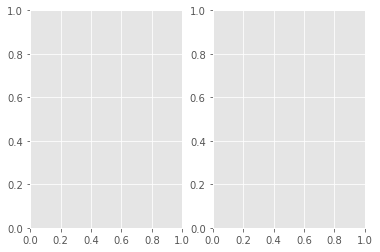

In [14]:
def plot_output(ax, output, title=None):
    ax.set_title(title)
    ax.plot(output)
    ax.set_xlabel('distance')
    ax.set_ylabel('y')
def scatter_output(ax, output, title=None):
    ax.set_title(title)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=output)
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    ax.set_aspect('equal')

fig, axes = plt.subplots(ncols=2)
print(us.shape)
scatter_output(axes[0], us.transpose(1, 2).reshape(-1), 'Prediction')
scatter_output(axes[1], data.iloc[:, 3], 'Actual')
plt.tight_layout()
fig, axes = plt.subplots(ncols=2)
plot_output(axes[0], us[0, 4, :], 'Prediction')
plot_output(axes[1], data[data['t'] == ts[4]].iloc[:, 3], 'Actual')

Text(0, 0.5, 'u')

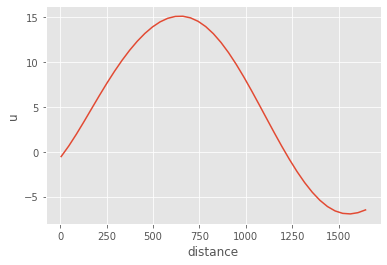

In [94]:
plt.plot(data[data['t'] == ts[5]].iloc[:, 2])
plt.xlabel('distance')
plt.ylabel('u')

In [ ]:
# Create N sets of input
N = 10
f = torch.rand(N, 1, requires_grad=True, dtype=torch.float64)
g = torch.rand(N, 1, requires_grad=True, dtype=torch.float64)
print(f.shape)
#g are the boundary conditions
# Solve the Poisson equation N times
u = poisson(f)

In [ ]:
from fenics import *
import time

T = 2.0            # final time
num_steps = 50     # number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 30
mesh = RectangleMesh(Point(0, 0), Point(2, 2), nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, Constant(0), boundary)

# Define initial value
u_0 = Constant(1)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

a = u*v*dx + dt*dot(grad(u), grad(v))*dx

# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):
    L = (u_n + dt*f)*v*dx

    # Update current time
    t += dt

    # Compute solution
    solve(a == L, u, bc)

    # Save to file and plot solution
    vtkfile << (u, t)
    # plot(u)


    # Update previous solution
    u_n.assign(u)

# Hold plot

<class 'dolfin.function.function.Function'>


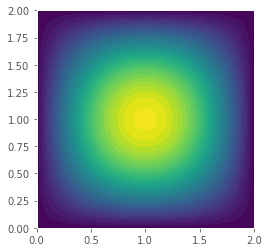

In [94]:
plot(u)
print(type(u))

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


AttributeError: 'dolfin.cpp.la.PETScVector' object has no attribute 'array'

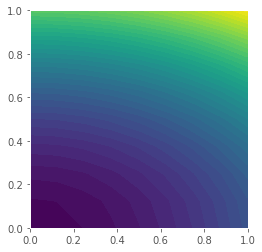

In [97]:
T = 2.0            # final time
num_steps = 10     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = interpolate(u_D, V)
    error = np.abs(u_e.vector().array() - u.vector().array()).max()
    print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
